In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import pandas as pd
import numpy as np
import os
import gc
import io
import warnings
import cv2 as cv
from Utils import * 

warnings.filterwarnings("ignore")

df = pd.read_csv('heart_failure_raw.csv')

# Pytorch

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tfrecord.torch.dataset import TFRecordDataset

import torchxrayvision as xrv
import torchvision
from torchvision import models, datasets

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:4096"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


# Test on specific demographic group

In [3]:
tfrecord_path = "LUNA/HF_comorbidities_test.tfrecords"
index_path = None
description = {"jpg_bytes": "byte", "Label": "int", "Race": "int", "Age": "int", "Gender": "int", "CAD": "int", "COPD": "int", "Asthma": "int", "CKD": "int", "Diabetes": "int", "Hypertension": "int", "ND": "int", "Dementia": "int", "LC": "int", "RibF": "int", "Pneumothorax": "int", "Pneumonia": "int"}
test_dataset = TFRecordDataset(tfrecord_path, index_path = None, description = description, transform = data_transform['original'])
test_loader = torch.utils.data.DataLoader(test_dataset)

In [4]:
from joblib import dump, load

RF_model = load('random_forest_model.joblib')
# RF_model = load('random_forest_model_plus.joblib')

In [5]:
# ['DenseNet121_chex', 'MobileNetV3', 'EfficientNetV2', 'ResNet18', 'RegNet', 'ShuffleNetV2', 'MNASNet']

In [6]:
import matplotlib.pyplot as plt

races = []
ages = []
genders = []

cads = []
copds = []
asthmas = []
ckds = []
diabetess = []
hypertensions = []
nds = []
dementias = []
lcs = []
ribfs = []
pneumothoraxs = []
pneumonias = []

y_preds = [[] for j in range(5)]

y_test = []
X_test = []

models = []

sigmoid = torch.nn.Sigmoid()

archi = 'DenseNet121_chex'

for rounds in range(5):
    models.append(define_model(archi))

    # models[rounds].load_state_dict(torch.load('LUNA_checkpoints_no_oversampling/{}/{}_{}_wfish_strong'.format(archi, archi, rounds), map_location=device))
    models[rounds].load_state_dict(torch.load('LUNA_checkpoints_no_oversampling/{}/{}_{}_wfish_strong'.format(archi, archi, rounds), map_location=device))
    # models[rounds].load_state_dict(torch.load('LUNA_checkpoints_no_oversampling/{}/{}_{}_original'.format(archi, archi, rounds), map_location=device))
    models[rounds].to(device)

    models[rounds].eval()


with torch.no_grad():
    for i, tdata in enumerate(test_loader):
        tinputs, tlabels, traces, tages, tgenders, tcad, tcopd, tasthma, tckd, tdiabetes, thypertension, tnd, tdementia, tlc, tribf, tpneumothorax, tpneumonia= tdata['jpg_bytes'], tdata['Label'], tdata['Race'], tdata['Age'], tdata['Gender'], tdata['CAD'], tdata['COPD'], tdata['Asthma'], tdata['CKD'], tdata['Diabetes'], tdata['Hypertension'], tdata['ND'], tdata['Dementia'], tdata['LC'], tdata['RibF'], tdata['Pneumothorax'], tdata['Pneumonia']

        tinputs = tinputs.float().to(device)
        tlabels = tlabels.float().to(device)
        
        
        y_test.append(tlabels.item())
        races.append(traces.item())
        ages.append(tages.item())
        genders.append(tgenders.item())
        
        cads.append(tcad.item())
        copds.append(tcopd.item())
        asthmas.append(tasthma.item())
        ckds.append(tckd.item())
        diabetess.append(tdiabetes.item())
        hypertensions.append(thypertension.item())
        nds.append(tnd.item())
        dementias.append(tdementia.item())
        lcs.append(tlc.item())
        ribfs.append(tribf.item())
        pneumothoraxs.append(tpneumothorax.item())
        pneumonias.append(tpneumonia.item())

        for i in range(5):
            toutputs = sigmoid(models[i](tinputs))
            y_preds[i].append(toutputs.item())

In [7]:
y_preds = np.array(y_preds)
y_test = np.array(y_test)
races = np.array(races)
ages = np.array(ages)
genders = np.array(genders)
cad = np.array(cads)
copd = np.array(copds)
asthma = np.array(asthmas)
ckd = np.array(ckds)
diabetes = np.array(diabetess)
hypertension = np.array(hypertensions)
nd = np.array(nds)
dementia = np.array(dementias)
lc = np.array(lcs)
ribf = np.array(ribfs)
pneumothorax = np.array(pneumothoraxs)
pneumonia = np.array(pneumonias)

In [8]:
RF_x_test=[]
for i in range(len(y_test)):
    sub_x = []
    sub_x.append(races[i])
    sub_x.append(ages[i])
    sub_x.append(genders[i])
    sub_x.append(cad[i])
    sub_x.append(copd[i])
    sub_x.append(asthma[i])
    sub_x.append(ckd[i])
    sub_x.append(diabetes[i])
    sub_x.append(hypertension[i])
    sub_x.append(nd[i])
    sub_x.append(dementia[i])
    sub_x.append(lc[i])
    sub_x.append(ribf[i])
    sub_x.append(pneumothorax[i])
    sub_x.append(pneumonia[i])

    RF_x_test.append(sub_x)

RF_x_test = np.array(RF_x_test)
RF_x_test = RF_x_test.astype(np.float64)

In [9]:
RF_y_preds=RF_model.predict_proba(RF_x_test)[:, 1] 
roc_auc = roc_auc_score(y_test, RF_y_preds) 
print(roc_auc)

0.7325343613811599


In [10]:
total_comorbidities = []
for idx in range(len(cad)):
    temp = []
    temp.append(cad[idx])
    temp.append(copd[idx])
    temp.append(asthma[idx])
    temp.append(ckd[idx])
    temp.append(diabetes[idx])
    temp.append(hypertension[idx])
    temp.append(nd[idx])
    temp.append(dementia[idx])
    temp.append(lc[idx])
    temp.append(ribf[idx])
    temp.append(pneumothorax[idx])
    temp.append(pneumonia[idx])
    total_comorbidities.append(temp)

## Overall

[0.7516929265839759, 0.7475695608447872, 0.7619175326852162, 0.7458933959101576, 0.7551458263493128]
AUC : 0.75, CI: [0.74 - 0.77]
ACC : 0.59, CI: [0.55 - 0.63]
F1 score : 0.59, CI: [0.55 - 0.63]
Thresh: 0.5785401936901946


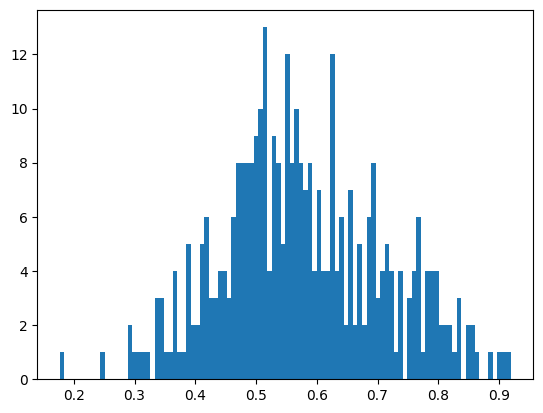

In [11]:
auc4amodel = []
acc4amodel = []
f14amodel = []

for i in range(5):
    
    y_prob = (RF_y_preds + y_preds[i])/2
    
    fpr, tpr, threshes = metrics.roc_curve(y_test,  y_prob)

    best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

    auc4amodel.append(metrics.auc(fpr, tpr))
    
    best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

    acc4amodel.append(metrics.accuracy_score(y_test,  np.where(y_preds[i] >= best_thresh, 1, 0)))

    f14amodel.append(metrics.f1_score(y_test,  np.where(y_preds[i] >= best_thresh, 1, 0), average='weighted'))

print(auc4amodel)

get_CI('AUC', auc4amodel)
get_CI('ACC', acc4amodel)
get_CI('F1 score', f14amodel)

print('Thresh:', best_thresh)
plt.hist(np.mean(y_preds, axis=0), bins=100)
plt.show()

## Race

WHITE
243
AUC : 0.73, CI: [0.72 - 0.74]
ACC : 0.58, CI: [0.56 - 0.60]
F1 score : 0.58, CI: [0.56 - 0.60]


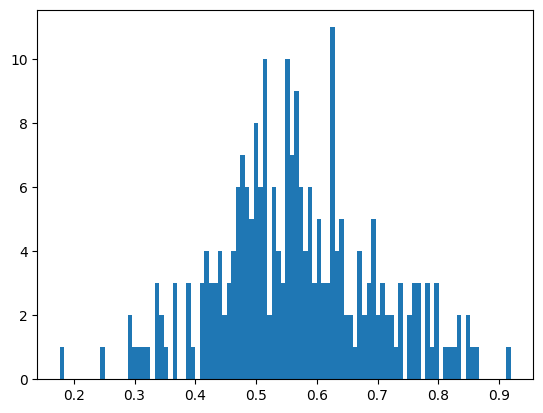

----------------------------
BLACK/AFRICAN AMERICAN
50
AUC : 0.71, CI: [0.67 - 0.75]
ACC : 0.64, CI: [0.57 - 0.72]
F1 score : 0.63, CI: [0.55 - 0.72]


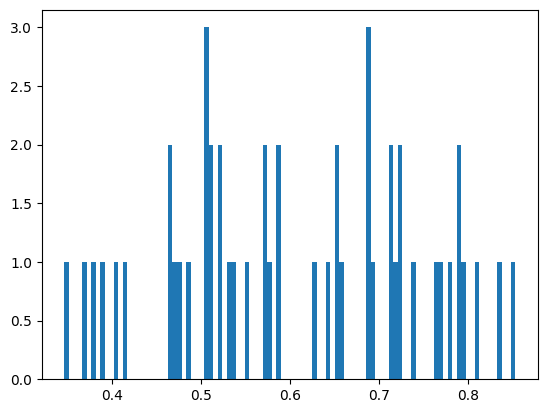

----------------------------
HISPANIC/LATINO
13
AUC : 0.79, CI: [0.73 - 0.85]
ACC : 0.52, CI: [0.32 - 0.73]
F1 score : 0.49, CI: [0.28 - 0.71]


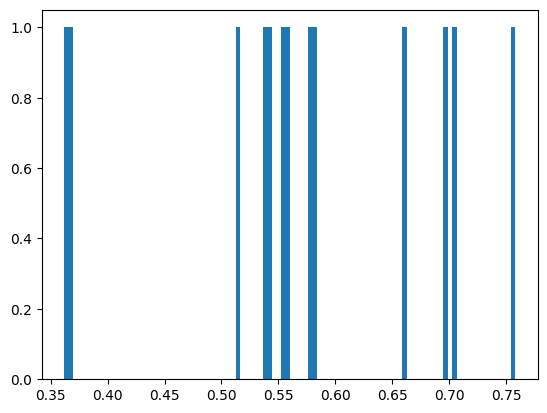

----------------------------
OTHER
35
AUC : 0.88, CI: [0.87 - 0.90]
ACC : 0.60, CI: [0.48 - 0.72]
F1 score : 0.59, CI: [0.49 - 0.70]


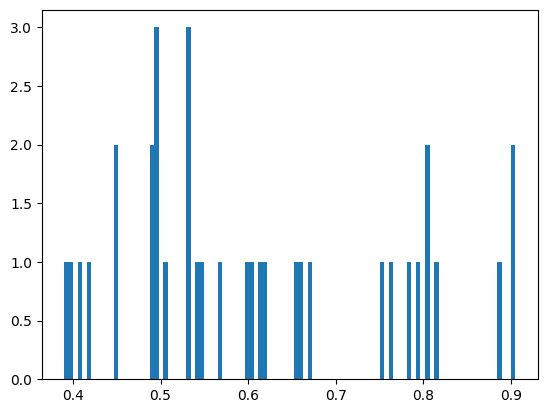

----------------------------
ASIAN
6
AUC : 1.00, CI: [1.00 - 1.00]
ACC : 0.57, CI: [0.38 - 0.75]
F1 score : 0.56, CI: [0.36 - 0.76]


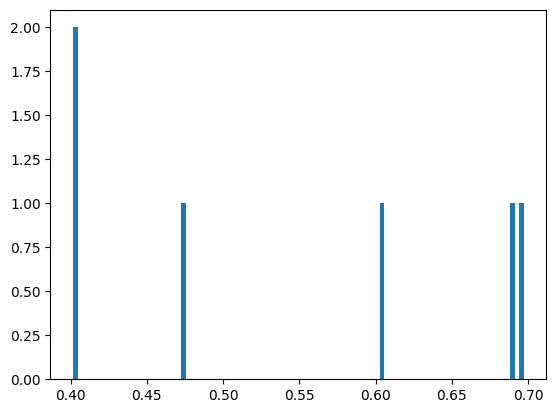

----------------------------


In [12]:
race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']

for group in np.unique(races):
    
    print(race_list[group])
    
    idx = np.where(races == group)[0]
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):

        y_prob = (RF_y_preds[idx] + y_preds[i, idx])/2
    
        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_prob)

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))
    
    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')

WHITE
243
AUC : 0.73, CI: [0.72 - 0.74]
ACC : 0.58, CI: [0.56 - 0.60]
F1 score : 0.58, CI: [0.56 - 0.60]


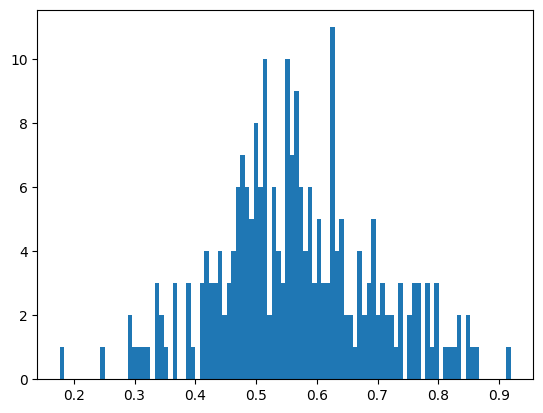

----------------------------
BLACK/AFRICAN AMERICAN
50
AUC : 0.71, CI: [0.67 - 0.75]
ACC : 0.64, CI: [0.57 - 0.72]
F1 score : 0.63, CI: [0.55 - 0.72]


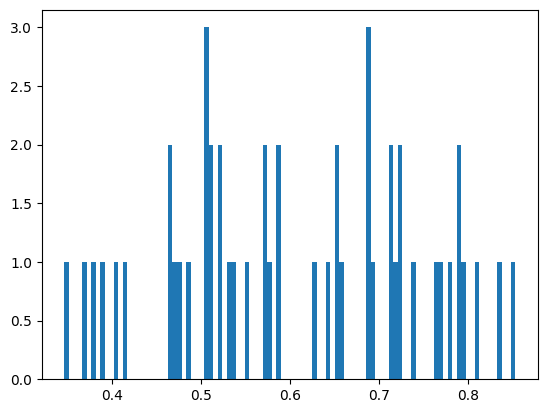

----------------------------
Hispanic+Asian
[ 21  23  49  98 143 159 210 224 227 243 247 278 313]
[ 65  97 107 110 194 280]
[21, 23, 49, 98, 143, 159, 210, 224, 227, 243, 247, 278, 313, 65, 97, 107, 110, 194, 280]
19
AUC : 0.86, CI: [0.79 - 0.93]
ACC : 0.49, CI: [0.25 - 0.74]
F1 score : 0.48, CI: [0.20 - 0.75]


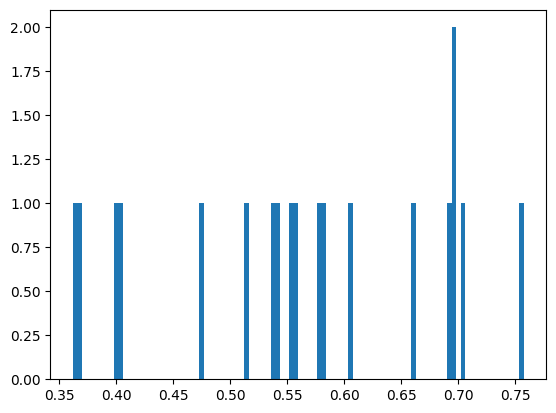

----------------------------


In [13]:
race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']

for group in np.unique(races):
    
    if(group==3 or group==4):
        continue
    elif(group==2):
        print("Hispanic+Asian")
        idx1 = np.where(races == group)[0]
        idx2 = np.where(races == 4)[0]
        print(idx1)
        print(idx2)
        idx = []
        idx = idx + list(idx1) + list(idx2)
        print(idx)
    else:
        print(race_list[group])
        idx = np.where(races == group)[0]
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):

        y_prob = (RF_y_preds[idx] + y_preds[i, idx])/2
    
        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_prob)

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))

    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')

## Age

0-65
109
AUC : 0.84, CI: [0.82 - 0.86]
ACC : 0.63, CI: [0.54 - 0.72]
F1 score : 0.63, CI: [0.54 - 0.72]


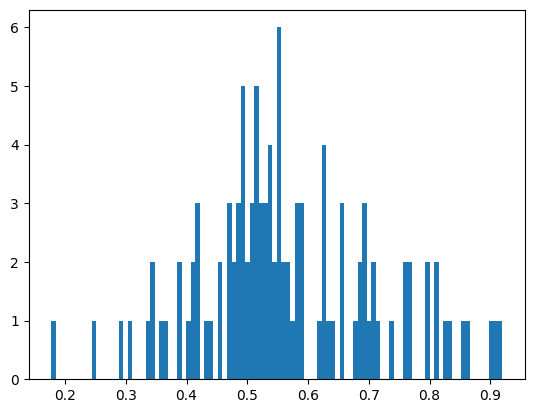

----------------------------
65-80
124
AUC : 0.65, CI: [0.62 - 0.68]
ACC : 0.56, CI: [0.52 - 0.59]
F1 score : 0.53, CI: [0.41 - 0.64]


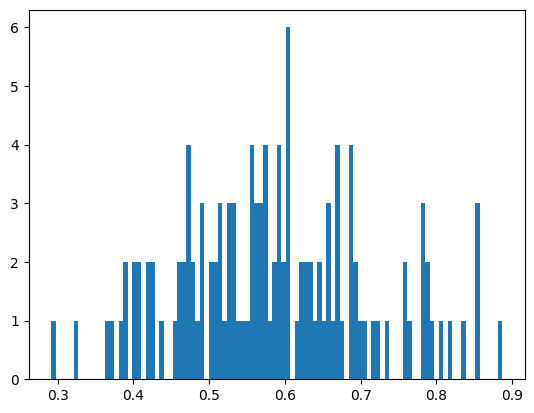

----------------------------
80+
114
AUC : 0.76, CI: [0.74 - 0.78]
ACC : 0.59, CI: [0.50 - 0.68]
F1 score : 0.58, CI: [0.45 - 0.71]


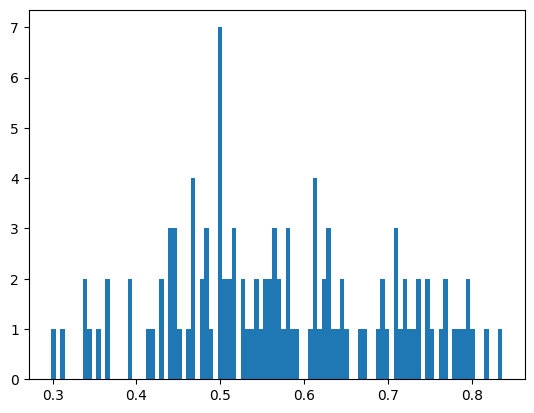

----------------------------


In [14]:
age_list = ['0-65', '65-80', '80+']

for group in np.unique(ages):
    
    print(age_list[group])
    
    idx = np.where(ages == group)[0]
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):

        y_prob = (RF_y_preds[idx] + y_preds[i, idx])/2
        
        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_prob)

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))
    
    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')

## Gender

Male
152
AUC : 0.72, CI: [0.70 - 0.74]
ACC : 0.54, CI: [0.43 - 0.64]
F1 score : 0.53, CI: [0.41 - 0.65]


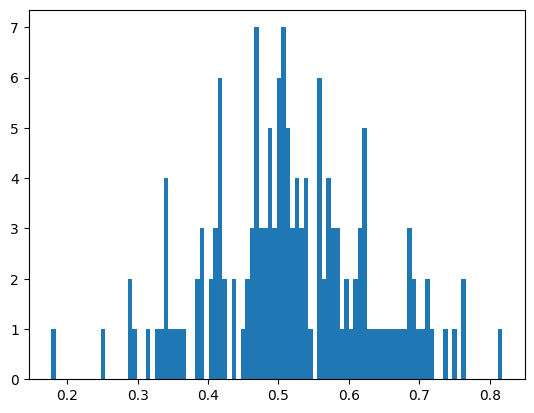

----------------------------
Female
195
AUC : 0.72, CI: [0.70 - 0.75]
ACC : 0.53, CI: [0.42 - 0.64]
F1 score : 0.53, CI: [0.40 - 0.66]


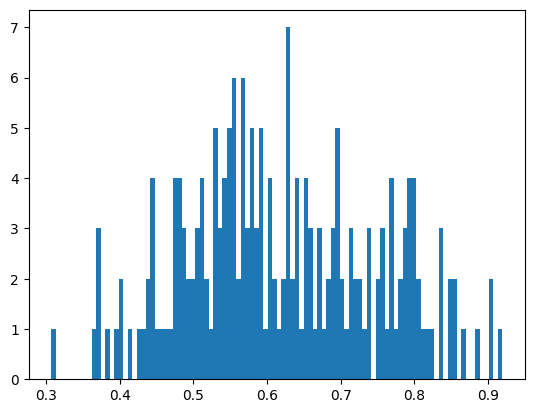

----------------------------


In [15]:
gender_list = ['Male', 'Female']

for group in np.unique(genders):
    
    print(gender_list[group])
    
    idx = np.where(genders == group)[0]
    
    print(len(idx))
    
    auc4amodel = []
    acc4amodel = []
    f14amodel = []

    for i in range(5):

        y_prob = (RF_y_preds[idx] + y_preds[i, idx])/2

        fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_prob)

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
        
        auc4amodel.append(metrics.auc(fpr, tpr))

        best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

        acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

        f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))

    get_CI('AUC', auc4amodel)
    get_CI('ACC', acc4amodel)
    get_CI('F1 score', f14amodel)
    
    plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
    plt.show()

    print('----------------------------')

## Intersection

0 0 0
WHITE 0-65 Male
[5, 9, 53, 66, 94, 95, 101, 102, 103, 106, 109, 121, 122, 132, 145, 152, 155, 172, 180, 190, 201, 205, 207, 214, 219, 242, 255, 277, 281, 283, 292, 310, 312, 331]
34
AUC : 0.79, CI: [0.71 - 0.86]
ACC : 0.56, CI: [0.46 - 0.67]
F1 score : 0.57, CI: [0.46 - 0.68]


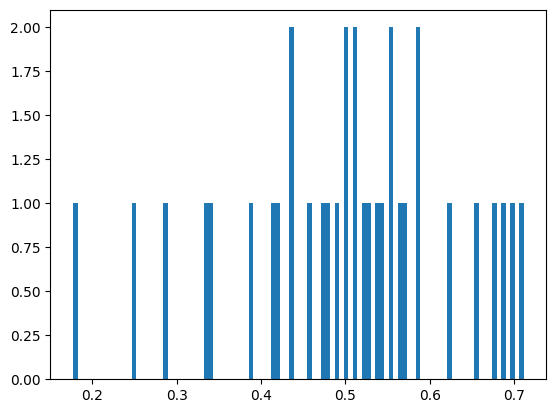

----------------------------
0 0 1
WHITE 0-65 Female
[22, 44, 75, 77, 80, 81, 111, 113, 125, 130, 141, 154, 188, 199, 203, 204, 211, 216, 217, 232, 233, 238, 245, 260, 265, 271, 274, 286, 287, 317, 332, 345]
32
AUC : 0.86, CI: [0.82 - 0.89]
ACC : 0.68, CI: [0.58 - 0.77]
F1 score : 0.67, CI: [0.59 - 0.76]


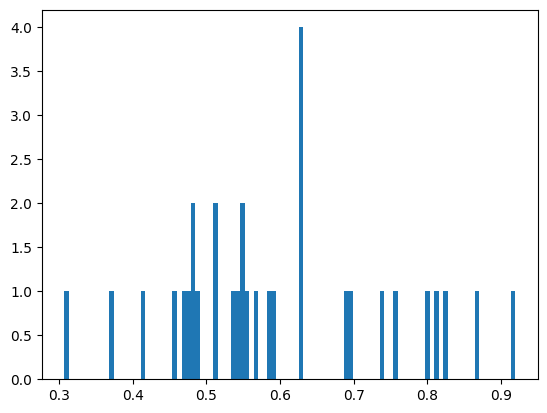

----------------------------
0 1 0
WHITE 65-80 Male
[7, 15, 19, 36, 42, 46, 54, 57, 68, 83, 84, 105, 108, 123, 137, 144, 146, 150, 166, 170, 176, 178, 182, 191, 195, 200, 215, 225, 228, 231, 263, 264, 269, 272, 275, 293, 294, 296, 297, 302, 343]
41
AUC : 0.56, CI: [0.50 - 0.62]
ACC : 0.57, CI: [0.46 - 0.67]
F1 score : 0.53, CI: [0.41 - 0.64]


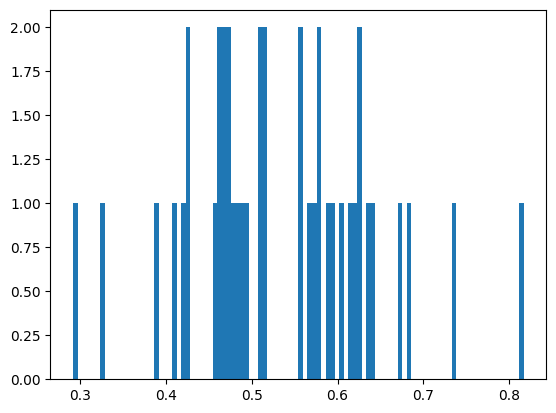

----------------------------
0 1 1
WHITE 65-80 Female
[1, 6, 47, 51, 52, 58, 69, 71, 73, 76, 87, 89, 91, 99, 104, 115, 119, 127, 131, 134, 142, 147, 148, 165, 175, 181, 189, 193, 208, 221, 223, 235, 237, 244, 268, 282, 299, 300, 311, 325, 330, 333, 334, 346]
44
AUC : 0.65, CI: [0.60 - 0.71]
ACC : 0.59, CI: [0.54 - 0.64]
F1 score : 0.57, CI: [0.46 - 0.67]


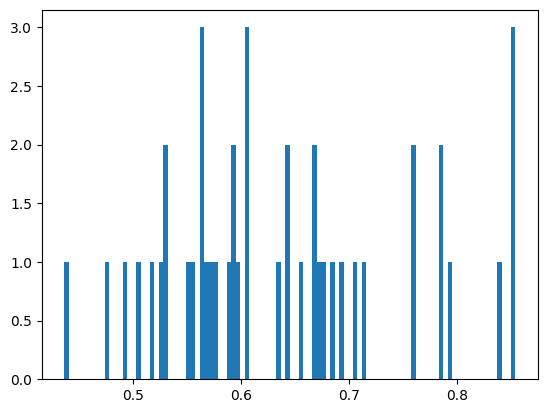

----------------------------
0 2 0
WHITE 80+ Male
[0, 20, 33, 40, 50, 67, 70, 78, 93, 117, 124, 126, 135, 163, 164, 167, 174, 185, 197, 198, 226, 251, 254, 256, 259, 261, 285, 306, 321, 326, 336, 338, 341, 342]
34
AUC : 0.70, CI: [0.65 - 0.76]
ACC : 0.60, CI: [0.45 - 0.75]
F1 score : 0.59, CI: [0.44 - 0.74]


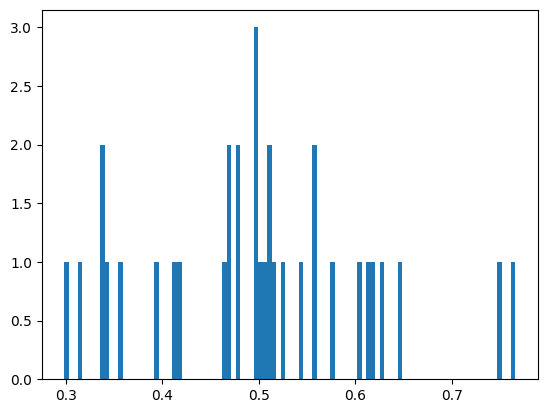

----------------------------
0 2 1
WHITE 80+ Female
[3, 4, 11, 13, 14, 18, 26, 30, 31, 39, 55, 62, 64, 72, 88, 96, 100, 112, 114, 128, 129, 133, 136, 138, 139, 140, 149, 151, 153, 156, 162, 169, 171, 184, 186, 187, 209, 218, 230, 239, 246, 252, 253, 257, 273, 288, 290, 291, 295, 304, 308, 309, 315, 327, 335, 337, 339, 344]
58
AUC : 0.66, CI: [0.62 - 0.70]
ACC : 0.43, CI: [0.31 - 0.56]
F1 score : 0.43, CI: [0.26 - 0.60]


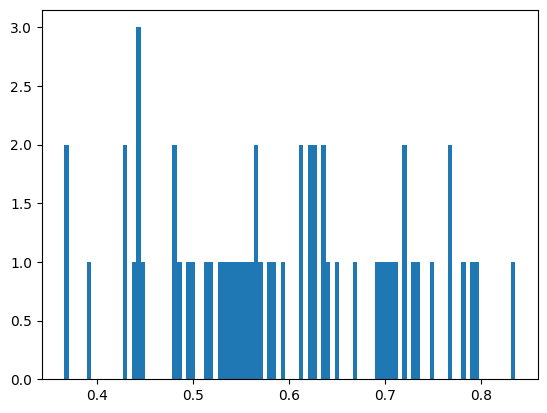

----------------------------
1 0 0
BLACK/AFRICAN AMERICAN 0-65 Male
[12, 74, 116, 177, 179, 220, 267, 284, 319]
9
AUC : 0.73, CI: [0.67 - 0.79]
ACC : 0.47, CI: [0.37 - 0.57]
F1 score : 0.37, CI: [0.18 - 0.57]


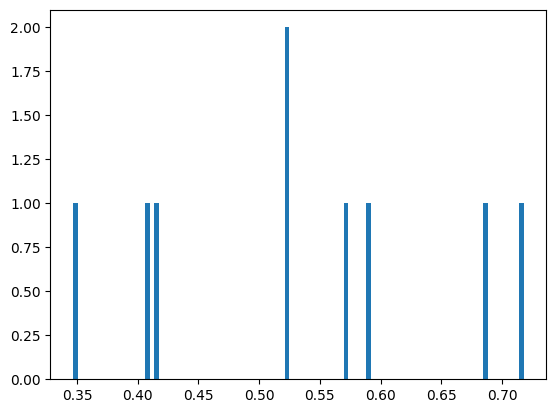

----------------------------
1 0 1
BLACK/AFRICAN AMERICAN 0-65 Female
[10, 86, 120, 161, 173, 236, 250, 266, 303, 323, 328, 329]
12
AUC : 0.84, CI: [0.76 - 0.92]
ACC : 0.62, CI: [0.47 - 0.77]
F1 score : 0.66, CI: [0.51 - 0.81]


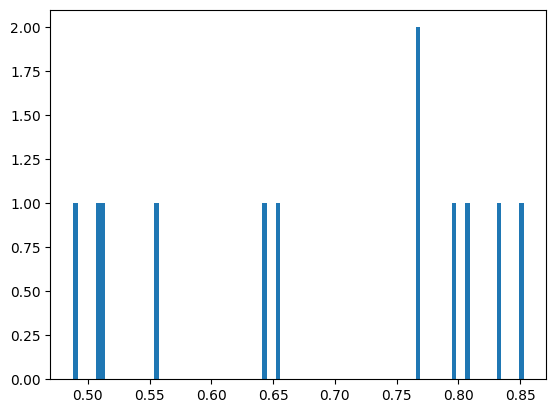

----------------------------
1 1 0
BLACK/AFRICAN AMERICAN 65-80 Male
[16, 43, 61, 79, 234]
5
AUC : nan, CI: [nan - nan]
ACC : 1.00, CI: [1.00 - 1.00]
F1 score : 1.00, CI: [1.00 - 1.00]


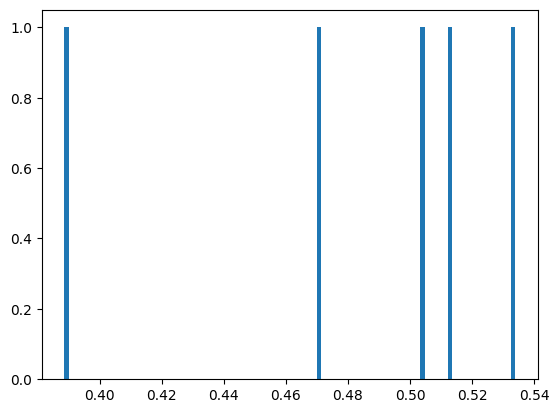

----------------------------
1 1 1
BLACK/AFRICAN AMERICAN 65-80 Female
[2, 25, 27, 32, 35, 60, 157, 158, 196, 212, 229, 305, 320, 324, 340]
15
AUC : 0.40, CI: [0.35 - 0.44]
ACC : 0.51, CI: [0.13 - 0.88]
F1 score : 0.42, CI: [-0.10 - 0.95]


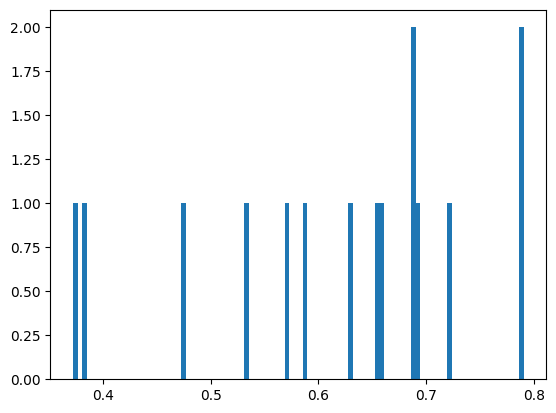

----------------------------
1 2 0
BLACK/AFRICAN AMERICAN 80+ Male
[28, 160, 183]
3
AUC : 0.30, CI: [-0.60 - 1.20]
ACC : 0.73, CI: [0.43 - 1.03]
F1 score : 0.65, CI: [0.24 - 1.06]


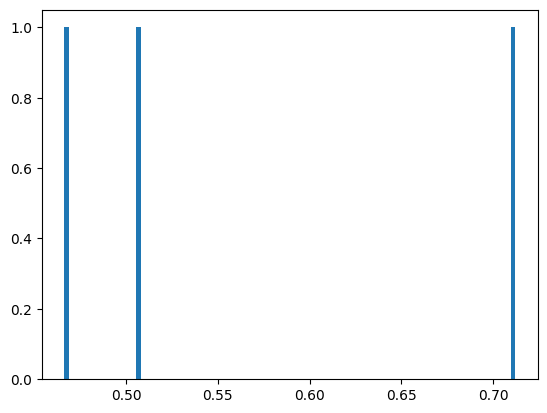

----------------------------
1 2 1
BLACK/AFRICAN AMERICAN 80+ Female
[37, 41, 59, 85, 168, 301]
6
AUC : 0.62, CI: [0.37 - 0.88]
ACC : 0.60, CI: [0.30 - 0.90]
F1 score : 0.55, CI: [0.18 - 0.93]


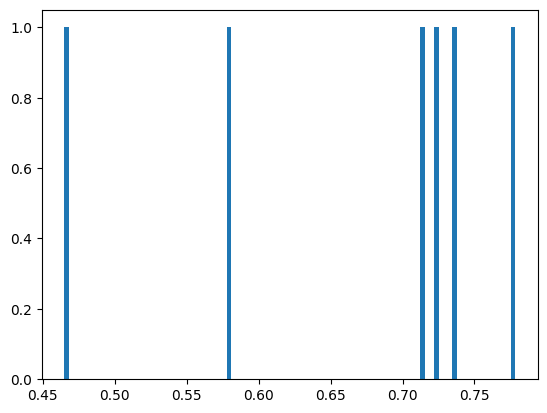

----------------------------
2 0 0
HISPANIC/LATINO 0-65 Male
[21, 49, 98, 159]
4
AUC : 1.00, CI: [1.00 - 1.00]
ACC : 0.90, CI: [0.62 - 1.18]
F1 score : 0.89, CI: [0.60 - 1.19]


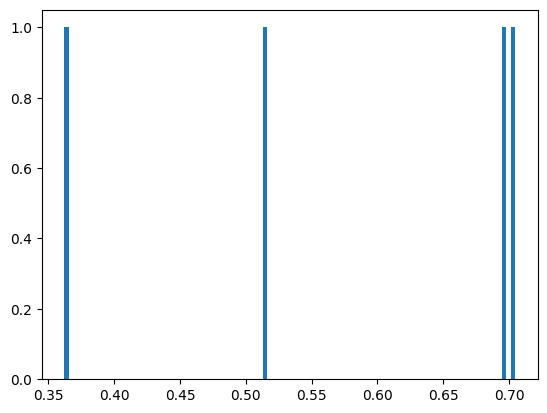

----------------------------
2 0 1
HISPANIC/LATINO 0-65 Female
[143, 210, 224, 278]
4
AUC : 0.50, CI: [0.50 - 0.50]
ACC : 0.30, CI: [0.07 - 0.53]
F1 score : 0.23, CI: [0.11 - 0.35]


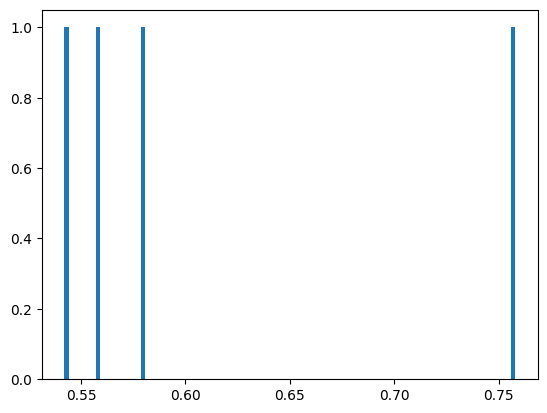

----------------------------
2 1 0
HISPANIC/LATINO 65-80 Male
[23, 243]
2
AUC : nan, CI: [nan - nan]
ACC : 0.00, CI: [0.00 - 0.00]
F1 score : 0.00, CI: [0.00 - 0.00]


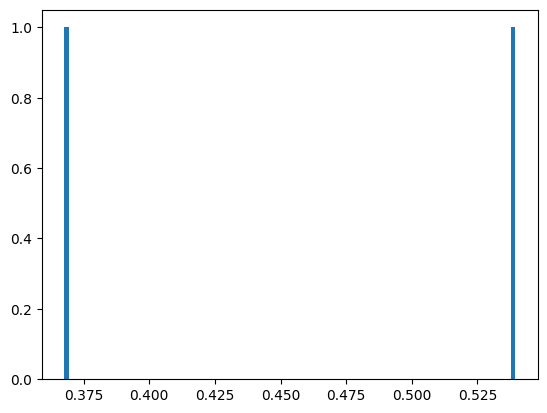

----------------------------
2 1 1
HISPANIC/LATINO 65-80 Female
[247, 313]
2
AUC : nan, CI: [nan - nan]
ACC : 1.00, CI: [1.00 - 1.00]
F1 score : 1.00, CI: [1.00 - 1.00]


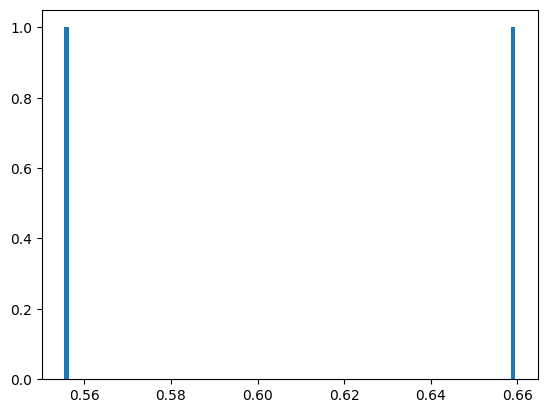

----------------------------
2 2 0
HISPANIC/LATINO 80+ Male
[]
0
NAN
2 2 1
HISPANIC/LATINO 80+ Female
[227]
1
AUC : nan, CI: [nan - nan]
ACC : 0.00, CI: [0.00 - 0.00]
F1 score : 0.00, CI: [0.00 - 0.00]


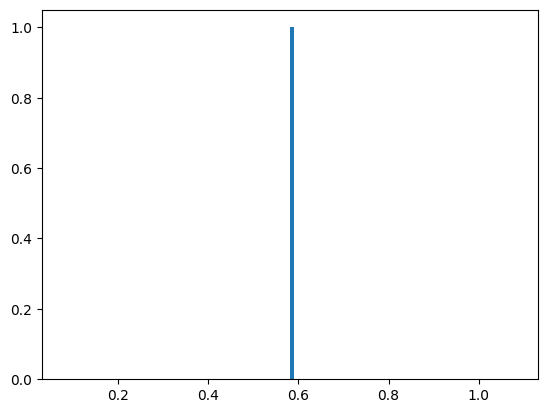

----------------------------
3 0 0
OTHER 0-65 Male
[17, 38, 92, 279, 289, 298]
6
AUC : 0.92, CI: [0.70 - 1.14]
ACC : 0.80, CI: [0.65 - 0.95]
F1 score : 0.74, CI: [0.66 - 0.82]


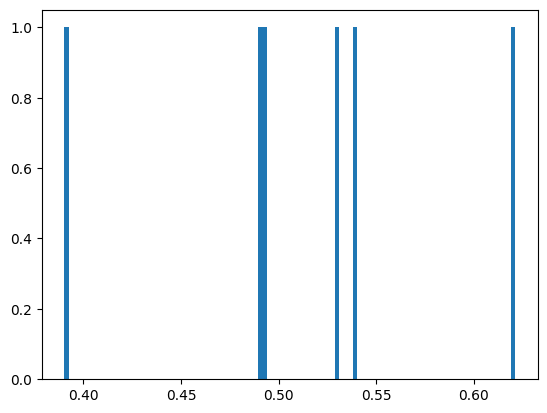

----------------------------
3 0 1
OTHER 0-65 Female
[45, 90, 202, 240, 248, 316]
6
AUC : 1.00, CI: [1.00 - 1.00]
ACC : 0.60, CI: [0.42 - 0.78]
F1 score : 0.64, CI: [0.46 - 0.83]


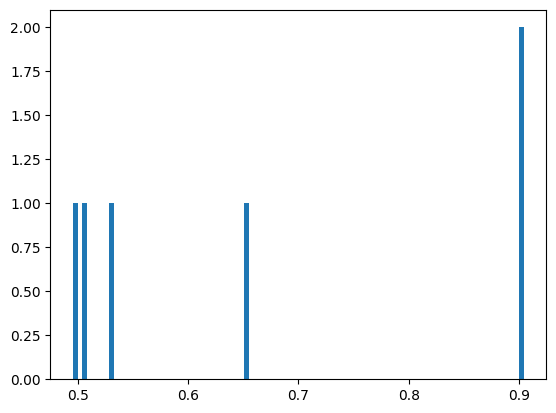

----------------------------
3 1 0
OTHER 65-80 Male
[192, 206, 213, 262, 270, 318, 322]
7
AUC : 0.85, CI: [0.77 - 0.93]
ACC : 0.57, CI: [0.37 - 0.78]
F1 score : 0.47, CI: [0.24 - 0.70]


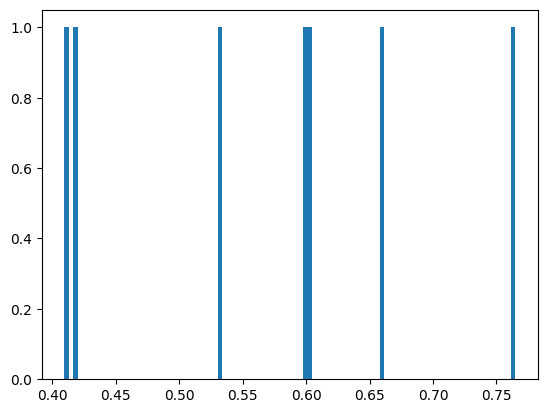

----------------------------
3 1 1
OTHER 65-80 Female
[8, 63, 118, 222, 258]
5
AUC : 0.73, CI: [0.43 - 1.03]
ACC : 0.24, CI: [0.06 - 0.42]
F1 score : 0.24, CI: [0.06 - 0.42]


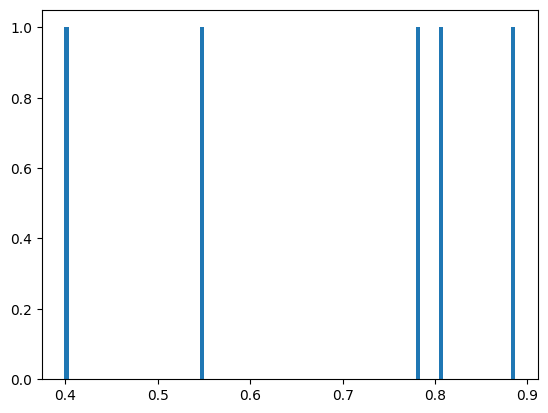

----------------------------
3 2 0
OTHER 80+ Male
[24, 34, 56, 276, 314]
5
AUC : nan, CI: [nan - nan]
ACC : 1.00, CI: [1.00 - 1.00]
F1 score : 1.00, CI: [1.00 - 1.00]


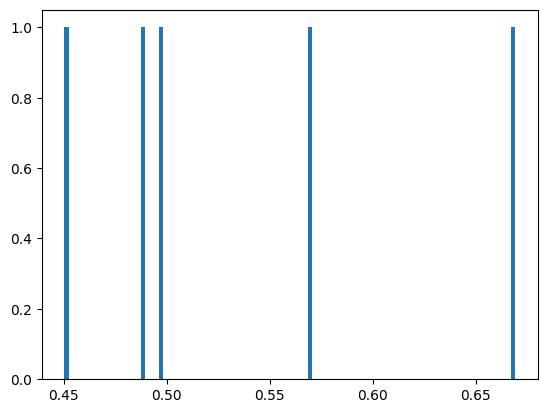

----------------------------
3 2 1
OTHER 80+ Female
[29, 48, 82, 241, 249, 307]
6
AUC : 1.00, CI: [1.00 - 1.00]
ACC : 0.73, CI: [0.55 - 0.92]
F1 score : 0.71, CI: [0.48 - 0.93]


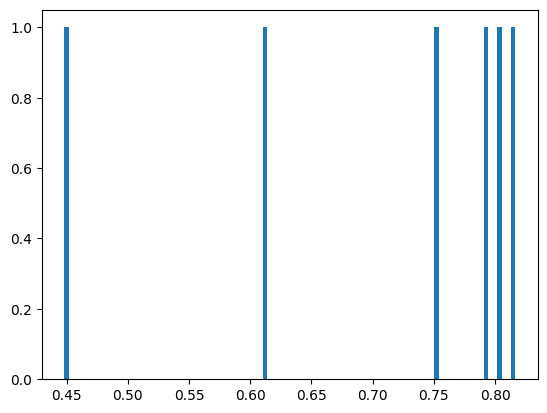

----------------------------
4 0 0
ASIAN 0-65 Male
[]
0
NAN
4 0 1
ASIAN 0-65 Female
[97, 110]
2
AUC : 1.00, CI: [1.00 - 1.00]
ACC : 0.50, CI: [0.50 - 0.50]
F1 score : 0.33, CI: [0.33 - 0.33]


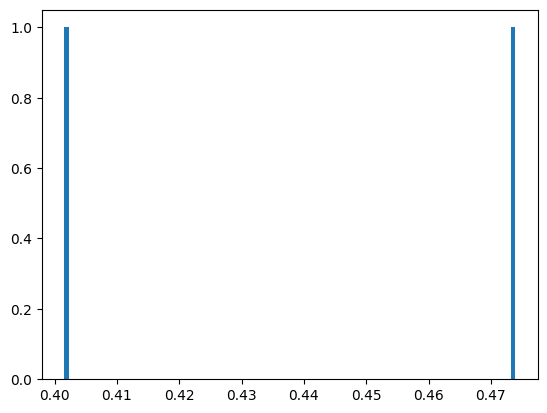

----------------------------
4 1 0
ASIAN 65-80 Male
[280]
1
AUC : nan, CI: [nan - nan]
ACC : 1.00, CI: [1.00 - 1.00]
F1 score : 1.00, CI: [1.00 - 1.00]


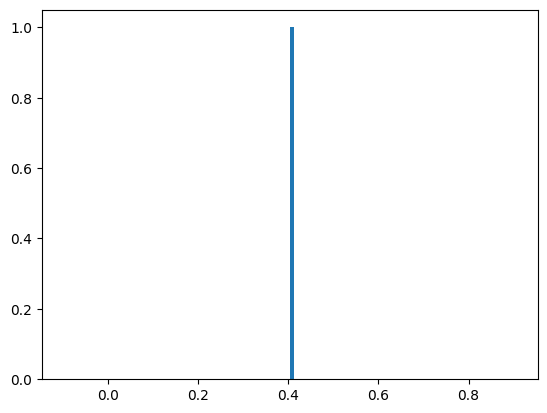

----------------------------
4 1 1
ASIAN 65-80 Female
[65, 194]
2
AUC : nan, CI: [nan - nan]
ACC : 0.00, CI: [0.00 - 0.00]
F1 score : 0.00, CI: [0.00 - 0.00]


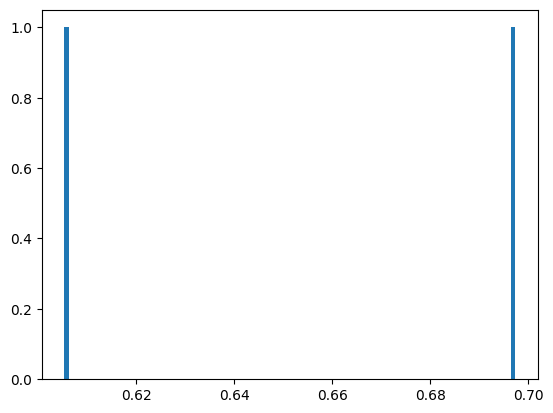

----------------------------
4 2 0
ASIAN 80+ Male
[107]
1
AUC : nan, CI: [nan - nan]
ACC : 1.00, CI: [1.00 - 1.00]
F1 score : 1.00, CI: [1.00 - 1.00]


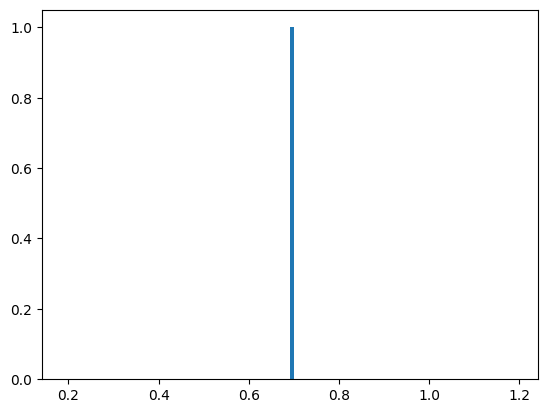

----------------------------
4 2 1
ASIAN 80+ Female
[]
0
NAN


In [16]:
race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']
age_list = ['0-65', '65-80', '80+']
gender_list = ['Male', 'Female']

count=0
mmax=0
mmin=0

for group1 in np.unique(races):
    for group2 in np.unique(ages):
        for group3 in np.unique(genders):
            # if (group1==0 and group2==1 and group3==0) or (group1==1 and group2==0 and group3==1):
            #     print("!!!")
            # else:
            #     continue
            print(group1, group2, group3)
            print(race_list[group1], age_list[group2], gender_list[group3])

            idx1 = np.where((races == group1))[0]
            idx2 = np.where((ages == group2))[0]
            idx3 = np.where((genders == group3))[0]
            idx = [x for x in idx1 if(x in idx2 and x in idx3)]
            count+=len(idx)
            
            print(idx)
            print(len(idx))
            if(len(idx)==0):
                print("NAN")
                continue
    
            auc4amodel = []
            acc4amodel = []
            f14amodel = []

            for i in range(5):

                y_prob = (RF_y_preds[idx] + y_preds[i, idx])/2

                # print(y_prob)
                # print(y_preds[i, idx])

                fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_prob)

                best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

                auc4amodel.append(metrics.auc(fpr, tpr))

                best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

                acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

                f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))
            
            get_CI('AUC', auc4amodel)
            get_CI('ACC', acc4amodel)
            get_CI('F1 score', f14amodel)

            plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
            plt.show()

            print('----------------------------')

In [17]:
            # new_auc4amodel = []
            # new_acc4amodel = []
            # new_f14amodel = []
            
            # auc4amodel = np.array(auc4amodel)
            # acc4amodel = np.array(acc4amodel)
            # f14amodel = np.array(f14amodel)
            
            # new_auc4amodel.append(auc4amodel.mean())
            # new_acc4amodel.append(acc4amodel.mean())
            # new_f14amodel.append(f14amodel.mean())
            
            # fpr, tpr, threshes = metrics.roc_curve(y_test,  RF_y_preds)
            # best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
            # new_auc4amodel.append(metrics.auc(fpr, tpr))
            # best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)
            # new_acc4amodel.append(metrics.accuracy_score(y_test,  np.where(y_preds[i] >= best_thresh, 1, 0)))
            # new_f14amodel.append(metrics.f1_score(y_test,  np.where(y_preds[i] >= best_thresh, 1, 0), average='weighted'))

In [18]:
print("Comorbidities")

Comorbidities


In [19]:
# race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']
# age_list = ['0-65', '65-80', '80+']
# gender_list = ['Male', 'Female']
# cormorbidities = ['CAD', 'COPD', 'Asthma', 'CKD', 'Diabetes', 'Hypertension', 'ND', 'Dementia', 'LC', 'RibF', 'Pneumothorax', 'Pneumonia']

# count=0
# for index in range(12):
#     for group1 in np.unique(races):
#         for group2 in np.unique(ages):
#             for group3 in np.unique(genders):
# #                 print(index, group1, group2, group3)
#                 print(cormorbidities[index], race_list[group1], age_list[group2], gender_list[group3])

#                 idx1 = np.where((races == group1))[0]
#                 idx2 = np.where((ages == group2))[0]
#                 idx3 = np.where((genders == group3))[0]
#                 idx = [x for x in idx1 if(x in idx2 and x in idx3 and total_comorbidities[x][index]==1)]

#                 print(idx)
#                 print(len(idx))
#                 if(len(idx)==0):
#                     print("NAN")
#                     continue

# #                 auc4amodel = []
# #                 acc4amodel = []
# #                 f14amodel = []

# #                 for i in range(5):

# #                     fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_preds[i, idx])

# #                     best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

# #                     auc4amodel.append(metrics.auc(fpr, tpr))

# #                     best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

# #                     acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

# #                     f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))

# #                 get_CI('AUC', auc4amodel)
# #                 get_CI('ACC', acc4amodel)
# #                 get_CI('F1 score', f14amodel)

# #                 plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
# #                 plt.show()

# #                 print('----------------------------')

In [20]:
# race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']
# age_list = ['0-65', '65-80', '80+']
# gender_list = ['Male', 'Female']
# cormorbidities = ['CAD', 'COPD', 'Asthma', 'CKD', 'Diabetes', 'Hypertension', 'ND', 'Dementia', 'LC', 'RibF', 'Pneumothorax', 'Pneumonia']

# for i in range(12):
#     for group1 in np.unique(races):
#         for group2 in np.unique(ages):
#             for group3 in np.unique(genders):
#                 print(group1, group2, group3)
#                 print(cormorbidities[i], race_list[group1], age_list[group2], gender_list[group3])

In [21]:
print(count)

347


In [22]:
print(len(total_comorbidities))

347


In [23]:
cnt=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in total_comorbidities:
    for j in range(12):
        if i[j]==1:
            cnt[j]+=1
print(cnt)

[72, 106, 43, 61, 159, 115, 38, 27, 7, 9, 9, 94]


In [24]:
cormorbidities = ['CAD', 'COPD', 'Asthma', 'CKD', 'Diabetes', 'Hypertension', 'ND', 'Dementia', 'LC', 'RibF', 'Pneumothorax', 'Pneumonia']

In [25]:
race_list = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'OTHER', 'ASIAN']
age_list = ['0-65', '65-80', '80+']
gender_list = ['Male', 'Female']
cormorbidities = ['CAD', 'COPD', 'Asthma', 'CKD', 'Diabetes', 'Hypertension', 'ND', 'Dementia', 'LC', 'RibF', 'Pneumothorax', 'Pneumonia']

count=0
for index in range(12):
    f1 = 0
    f2 = 0 
    print(cormorbidities[index])
    for group1 in np.unique(races):
        for group2 in np.unique(ages):
            for group3 in np.unique(genders):
#                 print(index, group1, group2, group3)
#                 print(cormorbidities[index], race_list[group1], age_list[group2], gender_list[group3])
                idx1 = np.where((races == group1))[0]
                idx2 = np.where((ages == group2))[0]
                idx3 = np.where((genders == group3))[0]
                idx = [x for x in idx1 if(x in idx2 and x in idx3 and total_comorbidities[x][index]==1)]
                
                if(group1 == 3):
                    f2+=len(idx)
                else:
                    f1+=len(idx)
#                 print(idx)
#                 print(len(idx))
                if(len(idx)==0):
#                     print("NAN")
                    continue

#                 auc4amodel = []
#                 acc4amodel = []
#                 f14amodel = []

#                 for i in range(5):

#                     fpr, tpr, threshes = metrics.roc_curve(y_test[idx],  y_preds[i, idx])

#                     best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

#                     auc4amodel.append(metrics.auc(fpr, tpr))

#                     best_thresh = get_optimal_youden_threshold(tpr, fpr, threshes)

#                     acc4amodel.append(metrics.accuracy_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0)))

#                     f14amodel.append(metrics.f1_score(y_test[idx],  np.where(y_preds[i, idx] >= best_thresh, 1, 0), average='weighted'))

#                 get_CI('AUC', auc4amodel)
#                 get_CI('ACC', acc4amodel)
#                 get_CI('F1 score', f14amodel)

#                 plt.hist(np.mean(y_preds, axis=0)[idx], bins=100)
#                 plt.show()

#                 print('----------------------------')
    print(f1, " ", f2)

CAD
59   13
COPD
94   12
Asthma
37   6
CKD
57   4
Diabetes
142   17
Hypertension
104   11
ND
33   5
Dementia
27   0
LC
7   0
RibF
7   2
Pneumothorax
7   2
Pneumonia
81   13


In [108]:
array1 = (RF_y_preds + y_preds[0])/2
array2 = (RF_y_preds + y_preds[1])/2
array3 = (RF_y_preds + y_preds[2])/2
array4 = (RF_y_preds + y_preds[3])/2
array5 = (RF_y_preds + y_preds[4])/2

y_prob = np.vstack([array1, array2, array3, array4, array5])

In [109]:
y_preds_temp = np.array(y_prob)

(347,)


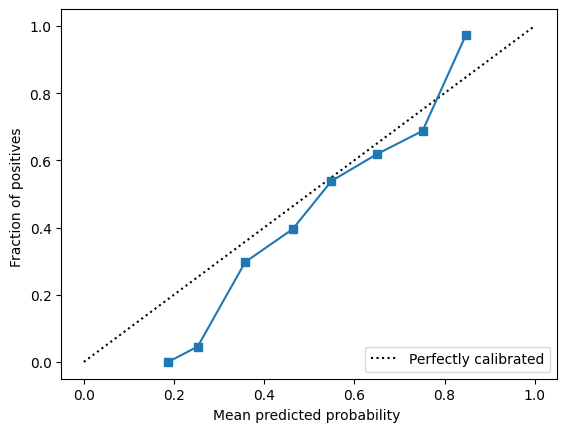

In [111]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

y_preds_temp = np.mean(y_preds_temp, axis=0)
print(y_preds_temp.shape)

prob_true, prob_pred = calibration_curve(y_test, y_preds_temp, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_preds_temp)
disp.plot()

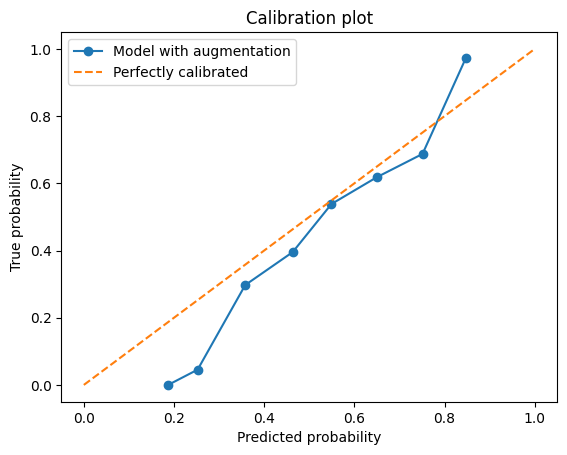

In [112]:
prob_true, prob_pred = calibration_curve(y_test, y_preds_temp, n_bins=10)

# 绘制校准图
plt.plot(prob_pred, prob_true, marker='o', label='Model with augmentation')

# 绘制完美校准的参考线
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

# 添加图例
plt.legend()

# 添加标签和标题
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot')

plt.savefig('multi-model_calibration_plot.png', bbox_inches='tight')

# 显示图表
plt.show()